# Laboratoire 3 - Caméra
Matériel fourni: règle en aluminium de 1 m, règle en plastique de 30 cm, rapporteur d'angle, repère vertical.

## Partie 0 - Interagir avec la caméra

D'abord, exécutons un peu de code de configuration, puis connectons-nous au robot.

In [1]:
%matplotlib nbagg

import numpy as np
import numpy.linalg as lin

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.use('nbagg')

from matplotlib import animation
mpl.rc('animation', html='html5') #display animated plots inline

from robmob.robot import Robot
from robmob.sensors import KinectRGBSensor
from robmob.visualization import Visualizer

In [2]:
ip_robot = '192.168.0.111'
robot = Robot(ip_robot)
robot.connect()

Le code suivant sert à créer ajouter la Kinect aux capteurs du robot.

In [3]:
kinect = KinectRGBSensor()
robot.add_sensor(kinect)

> **PROTIP** Aussitôt que vous exécutez la ligne `robot.add_sensor(kinect)`, le flux de la caméra est transmi 
> par le réseau du robot jusqu'à votre ordinateur. Comme ces données causent un bon traffic sur le routeur, 
> tentez de ne pas vous connecter à ce flux de données plusieurs fois en parallèle!

> **ATTENTION** Certaines Kinect sont branchées dans un hub USB au lieu d'être branchées directement dans l'ordinateur de bord. Si vous n'arrivez pas recevoir des images de la Kinect, mais que vous arrivez à vous connecter à d'autres capteurs du robot, tentez de brancher la Kinect directement dans l'ordinateur de bord.

## Acquisition d'images

Pour afficher la dernière image capturée par la Kinect, on peut utiliser `peek_data`.

In [ ]:
kinect.peek_data()

Même si ce n'est pas tout à fait nécessaire dans le cadre de ce laboratoire, on peut aussi afficher les images de la kinect en continu avec le code suivant.

In [ ]:
from IPython.display import display,HTML,clear_output
import time

N_OF_FRAMES_TO_DISPLAY = 100

for i in range(N_OF_FRAMES_TO_DISPLAY):
    clear_output(wait=True)
    display(kinect.peek_data())
    time.sleep(0.09999)

## Partie 1 - Calibration de la longueur focale

L'objectif de cette partie de de déterminer la longeur focale de la caméra du robot. Nous utiliserons la caméra RGB de la Kinect, en ignorant pour l'instant la partie infra-rouge des données.

Pour commencer, placez la règle de 1 m sur une table, puis placez le robot à une des extrémités de la règle. À l'autre extrémité, placez la règle de plastique de 30 cm à la même hauteur que la caméra, de sorte que la Kinect observe directement la règle de plastique. La caméra devrait être à environ 20 cm de la règle de plastique. Vous pouvez utiliser une feuille de papier derrière la règle de plastique pour rendre les mesures plus faciles à prendre. Votre assemblage devrait ressembler à l'image ci-bas.

![Assemblage pour la calibration](img/assemblage_calibration.jpg)

La commande ci-bas va afficher une image prise par la kinect dans une console interactive. Quand vous passez votre curseur de souris dans la console interactive, on devrait vous indiquer à quelle position, en pixel, se trouve votre curseur. Prenez en note la position de deux pixels qui sont à une distance connue. Par exemple, vous pourriez prendre en note la position de deux pixels qui sont à 5 cm de distance sur la règle. Pour vous faciliter la tâche, n'hésitez pas à utiliser le bouton *zoom to rectangle* de la console interactive, qui vous permettera de zoomer sur la règle et de voir les chiffres plus facilement.

> **Attention** Dans le présent *jupyter notebook*, il est important de fermer les figures (en appuyant sur le bouton bleu) quand vous avez terminé des les consulter. Jupyter ne semble pas capable d'afficher deux figures en même temps.

In [ ]:
plt.imshow(kinect.peek_data())

Utilisez le théorème de Thalès pour déduire la longeur focale de la caméra de la kinect. En guise de rappel, la longeur focale est donnée par 

$$ f = \Delta L_{caméra} \frac{A_z}{\Delta L_{réel}} $$

In [4]:
first_pixel = (132.205, 254.637)
second_pixel = (382.0, 251.569)

delta_l_camera = second_pixel[0] - first_pixel[0]
delta_l_reel = 30
distance_to_ruler = 60

f = delta_l_camera * distance_to_ruler / delta_l_reel
print('Longeur focale: {}'.format(f))

Longeur focale: 499.59


Pour valider vos calculs, déplacez la règle de plastique à une distance différente de la caméra. Toujours en utilisant le théorème de Thalès, estimez la distance $A_z$ en utilisant la longeur focale que vous avez trouvé. Votre estimation de $A_z$ et sa valeur réelle devraient être similaire.

## Partie 2 - Mesure d'angles

Comme mentionné en classe, la caméra est un rapporteur d'angle. Cette partie décrit comment faire des mesures d'angles avec la caméra du robot.

Placez deux objets dans le champ de vision de la caméra. En vous servant des règles et d'un rapporteur d'angle, mesurez l'angle approximatif entre ces deux objets, du point de vue de la caméra.

À l'aide de la commande suivante, trouvez les coordonnées en $x$ du centre de chacun des objets.

In [ ]:
plt.imshow(kinect.peek_data())

In [ ]:
p1 = 352
p2 = 506

Calculez l'angle $\theta$ entre les deux objets. Pour ce faire, vous devez considérer la distance en x (sur le plan image) entre le centre de l'objet et le centre optique de la caméra. Le centre optique passe au milieu de l'image, la colonne 320 dans notre cas. En guise de rappel, voici un schéma qui pourrait vous aider à calculer les angles nécessaires.

![](img/calcul_angle.png)

> **PROTIP** La fonction `arctan2` de numpy pourrait vous être utile! Comme nous avons renommé `numpy` pour `np` dans le haut du document, vous pouvez l'appeler en faisant `np.arctan2()`.

In [ ]:
lx1 = p1 - 320
theta1 = np.arctan2(lx1, f)

lx2 = p2 - 320
theta2 = np.arctan2(lx2, f)

angle_between_objects = np.degrees(theta2 - theta1)
print(angle_between_objects)

## Partie 3 - Localisation en deux dimensions

Placez cette fois trois objets sur le plancher, en vous servant des tuiles comme système cartésien. Le point de repère `p2` sera la position (0,0) de votre référentiel monde. Ce système de coordonnées aura comme unité de longeur une *tuile*, soit environ 30 cm. Placez deux autres objets aux intersections de tuiles, de sorte à avoir le montage ci-bas.

Avec le code suivant, capturez une image, puis notez la position en $x$ de chaque objet. Calculez l'angle $\alpha$ entre les objets 1 et 2 puis l'angle $\beta$ entre les objets 2 et 3.

In [ ]:
plt.imshow(kinect.peek_data())

In [61]:
def distance(p1, p2):
    return np.sqrt((p2[0,0] - p1[0,0])**2 + (p2[1,0] - p1[1,0])**2)

def alpha_beta_from_three_coordinates(f, c1, c2, c3):
    """Retourne l'angle entre l'objet 1 et 2, puis l'angle entre l'objet 2 et 3. Les
    arguments c1, c2, c3 sont la position en x de chaque objet dans l'image. f est la
    longeur focale."""
    
    position_of_optical_axis = 320
    
    positions = np.array([c1,c2,c3])
    thetas = np.degrees(np.arctan((positions - position_of_optical_axis) / f))
    
    return (thetas[1] - thetas[0], thetas[2] - thetas[1])

def circle_from_pts_and_angle(pts, angle):
    """Construit un cercle à partir de deux points de ce cercle et de l'angle
    entre ces deux points vu par un objet qui est aussi sur le cercle. pts doit
    être un tuple de points. Le point le plus à gauche doit toujours être donné
    en premier."""
    (p1, p2) = pts
    
    q = distance(p1,p2)
    m = (p1 - p2) / 2. + p2  # Point milieu entre les deux points connus
    v = np.array([[0, -1], [1, 0]]).dot(m - p2)  # Vecteur perpendiculaire à la droite reliant p1 et p2
    
    l = (q / 2) / np.tan(np.radians(angle)) # Distance entre le points milieu et le centre du cercle
    
    v = (v / lin.norm(v)) * l # Ajustement de la longeur du vecteur
    
    c = m + v # Centre du cercle
    r = (q / 2.) / np.sin(np.radians(angle)) # Rayon du cercle

    return (c.transpose()[0], r)

p1 = np.array([[-1.],[1.]])
p2 = np.array([[0.], [0.]])
p3 = np.array([[1.], [0.]])

(alpha, beta) = alpha_beta_from_three_coordinates(f, 229, 352, 506)

(c1, r1) = circle_from_pts_and_angle((p1,p2), alpha)
(c2, r2) = circle_from_pts_and_angle((p2,p3), beta)

print('Premier cercle centré en {} avec un rayon de {}'.format(c1, r1))
print('Second cercle centré en {} avec un rayon de {}'.format(c2, r2))

Premier cercle centré en [-2.50715943 -1.50715943] avec un rayon de 2.925299638521566
Second cercle centré en [ 0.5        -1.66072652] avec un rayon de 1.734362299643874


In [62]:
circle1 = plt.Circle((c1[0], c1[1]), r1, edgecolor='r', facecolor='none', linewidth=2.0)
circle2 = plt.Circle(c2, r2, edgecolor='b', facecolor='none', linewidth=2.0)

SQUARE_WIDTH = 0.2

square1 = plt.Rectangle((p1[0,0] - SQUARE_WIDTH/2, p1[1,0] - SQUARE_WIDTH/2), SQUARE_WIDTH, SQUARE_WIDTH, color='black')
square2 = plt.Rectangle((p2[0,0] - SQUARE_WIDTH/2, p2[1,0] - SQUARE_WIDTH/2), SQUARE_WIDTH, SQUARE_WIDTH, color='black')
square3 = plt.Rectangle((p3[0,0] - SQUARE_WIDTH/2, p3[1,0] - SQUARE_WIDTH/2), SQUARE_WIDTH, SQUARE_WIDTH, color='black')

fig, ax = (plt.gcf(), plt.gca())
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(square1)
ax.add_artist(square2)
ax.add_artist(square3)

ax.set_xticks(np.arange(-10,10,1))
ax.set_yticks(np.arange(-10,10,1))
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.grid()
plt.show()

## Partie 4 - Effet du bruit sur la localisation

Les fonctions qui suivent servent à montrer l'effet du bruit des mesures sur la position estimée du robot. Ici nos mesures sont les positions en x des repères dans l'image. La boucle qui suit va ajouter un bruit aléatoire (selon une distribution normale) sur vos mesures. Ensuite, elle recalcule la position du robot comme dans la partie précédente. Finalement, on trace un graphique de toutes les positions estimées.

In [63]:
plt.imshow(kinect.peek_data())

In [69]:
import numpy.random
from robmob.geometry import circle_intersection

m1 = 229.
m2 = 352.
m3 = 525.

measures = np.array([m1, m2, m3])

MEAN_NOISE = 0.0
NOISE_STD_DEV = 5.0


# Construire une liste d'hypothèses sur la position du robot.
intersection_list = np.empty((0,2))
for _ in range(100):
    # On ajoute un bruit gaussien aux mesures
    noisy_measures = measures + np.random.normal(MEAN_NOISE, NOISE_STD_DEV, (3))
    
    (alpha, beta) = alpha_beta_from_three_coordinates(f, *noisy_measures)
    
    noisy_c1 = circle_from_pts_and_angle((p1, p2), alpha)
    noisy_c2 = circle_from_pts_and_angle((p2, p3), beta)
    
    intersections = circle_intersection((noisy_c1[0][0], noisy_c1[0][1], noisy_c1[1]), 
                                        (noisy_c2[0][0], noisy_c2[0][1], noisy_c2[1]))
    
    new_rows = np.array([intersections[0], intersections[1]])
    intersection_list = np.concatenate([intersection_list, new_rows], axis=0)

<IPython.core.display.Javascript object>


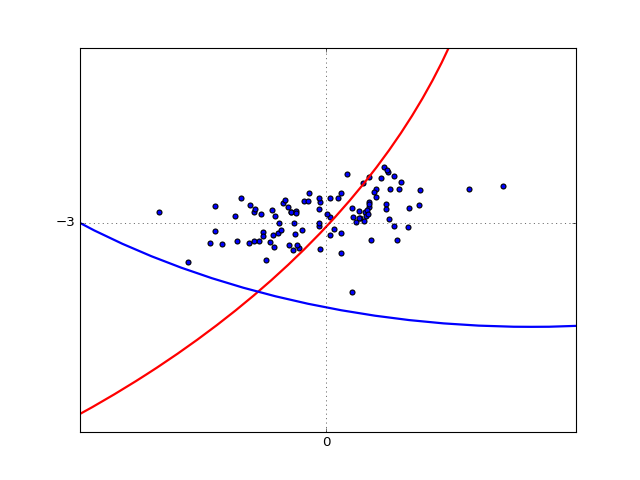

In [70]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

circle1 = plt.Circle(c1, r1, edgecolor='r', facecolor='none', linewidth=2.0)
circle2 = plt.Circle(c2, r2, edgecolor='b', facecolor='none', linewidth=2.0)

ax.add_patch(circle1)
ax.add_patch(circle2)

ax.scatter(intersection_list[:,0], intersection_list[:,1])

ax.set_xticks(np.arange(-10,10,1))
ax.set_yticks(np.arange(-10,10,1))
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.grid()

